In [1]:
import tensorflow as tf

# Set memory growth option for all available GPUs
gpus = tf.config.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus


2024-06-23 07:38:10.430358: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 07:38:10.430514: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 07:38:10.551436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
import shutil as sh
import keras
from keras import layers
from keras.optimizers import Adam
from keras import ops
import datetime
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
import math
import albumentations as A

In [3]:
import os

peep = os.listdir('/kaggle/input/data')
kee = []

for i in peep:
    if i.split('_')[0] == 'images':
        kee.append(i)

kee.sort()
kee


['images_001',
 'images_002',
 'images_003',
 'images_004',
 'images_005',
 'images_006',
 'images_007',
 'images_008',
 'images_009',
 'images_010',
 'images_011',
 'images_012']

In [4]:
img_paths = []
root_dir = '/kaggle/input/data'
c = 1
for i in kee:
    img_dir = os.path.join(os.path.join(root_dir,i),'images')
    for j in sorted(os.listdir(img_dir)):
        img_paths.append(os.path.join(img_dir,j))
        if(c<19):
            print(os.path.join(img_dir,j))
        c+=1

/kaggle/input/data/images_001/images/00000001_000.png
/kaggle/input/data/images_001/images/00000001_001.png
/kaggle/input/data/images_001/images/00000001_002.png
/kaggle/input/data/images_001/images/00000002_000.png
/kaggle/input/data/images_001/images/00000003_000.png
/kaggle/input/data/images_001/images/00000003_001.png
/kaggle/input/data/images_001/images/00000003_002.png
/kaggle/input/data/images_001/images/00000003_003.png
/kaggle/input/data/images_001/images/00000003_004.png
/kaggle/input/data/images_001/images/00000003_005.png
/kaggle/input/data/images_001/images/00000003_006.png
/kaggle/input/data/images_001/images/00000003_007.png
/kaggle/input/data/images_001/images/00000004_000.png
/kaggle/input/data/images_001/images/00000005_000.png
/kaggle/input/data/images_001/images/00000005_001.png
/kaggle/input/data/images_001/images/00000005_002.png
/kaggle/input/data/images_001/images/00000005_003.png
/kaggle/input/data/images_001/images/00000005_004.png


In [5]:
given_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
given_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
import pandas as pd

# Assuming given_df is your DataFrame containing the data
# Load the DataFrame from the given data
# given_df = pd.read_csv("your_dataset.csv")

# Splitting multiple labels in 'Finding Labels' column
single_label_df = given_df[given_df['Finding Labels'].str.split('|').apply(lambda x: len(x) == 1)]

# Counting the occurrence of each single label
label_counts = single_label_df['Finding Labels'].value_counts()

# Displaying the labels and their counts
print("Labels and their counts:")
print(label_counts)

Labels and their counts:
Finding Labels
No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Pneumonia               322
Hernia                  110
Name: count, dtype: int64


In [7]:
os.mkdir('/kaggle/working/Effusion')
os.mkdir('/kaggle/working/Normal')

In [8]:
A_dir = '/kaggle/working/Effusion'
N_dir = '/kaggle/working/Normal'

In [10]:
patient_ids = []
Effusion_c = 0
index_pointer = 0
for i in range(len(given_df)):
    if given_df.iloc[i,1] == 'Effusion' and Effusion_c<3000:
        sh.copy(img_paths[i],A_dir+'/'+img_paths[i].split('/')[-1])
#         patient_ids.append(given_df.iloc[i,3])
        index_pointer+=1
        Effusion_c+=1
    if(Effusion_c==3000 ):
        break
    if(index_pointer%100==0):
        print(index_pointer)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
100
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
300
400
400
400
400
400
400
400
400
500
500
500
500
600
600
700
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
800
900
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
110

In [11]:
os.listdir('/kaggle/working/Effusion')[-1]

'00014879_011.png'

In [12]:

Normal_c = 0
index_pointer = 0
for i in range(len(given_df)):
    if given_df.iloc[i,1] == 'No Finding' and Normal_c<9000:
#         custom_df_2.iloc[index_pointer,0] = img_paths[i]
#         patient_ids.append(given_df.iloc[i,3])
        sh.copy(img_paths[i],N_dir+'/'+img_paths[i].split('/')[-1])
        Normal_c+=1
        index_pointer+=1
        if(Normal_c==9000):
            break
        if(index_pointer%100==0):
            print(index_pointer)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900


In [14]:
os.listdir('/kaggle/working/Normal')[-1]

'00003360_007.png'

In [15]:
os.mkdir('/kaggle/working/'+'test')

In [16]:
# for augmentining
aug1 = A.Compose([
    A.HorizontalFlip(p=1),
])
aug2 = A.Compose([
    A.VerticalFlip(p=1)           
])

In [17]:
import os
import cv2
import imageio

i = 1
c = 1
A_dir = '/kaggle/working/Effusion/'

for filename in os.listdir(A_dir):
    print(filename)
    original_image = cv2.imread(os.path.join(A_dir, filename))
    augmented1 = aug1(image=original_image)['image']
    augmented2 = aug2(image=original_image)['image']
    new_img_path1 = os.path.join(A_dir, f"{filename.split('.')[0]}_{c}_aug1.png")
    new_img_path2 = os.path.join(A_dir, f"{filename.split('.')[0]}_{c}_aug2.png")
    imageio.imwrite(new_img_path1, augmented1)
    imageio.imwrite(new_img_path2, augmented2)
    c += 1
    if c%100==0 or c == 3000:
        print(c)


00010146_003.png
00019761_000.png
00009845_040.png
00007626_000.png
00008489_001.png
00019924_029.png
00018724_035.png
00009988_004.png
00016846_000.png
00019706_008.png
00020382_000.png
00020504_000.png
00003158_000.png
00006653_022.png
00006981_014.png
00017854_000.png
00006381_023.png
00016233_007.png
00015350_002.png
00009144_000.png
00017714_006.png
00011548_019.png
00017027_007.png
00006683_006.png
00009600_010.png
00010828_014.png
00013285_025.png
00018521_014.png
00014626_026.png
00017137_009.png
00003083_002.png
00020218_000.png
00002756_005.png
00005895_022.png
00019348_006.png
00006890_004.png
00005895_021.png
00017405_026.png
00016732_018.png
00001153_005.png
00006500_009.png
00010443_001.png
00014355_011.png
00009925_024.png
00005567_001.png
00015530_103.png
00020294_003.png
00007804_000.png
00020911_005.png
00002248_004.png
00015530_101.png
00010775_013.png
00015078_015.png
00012047_002.png
00005786_001.png
00014006_007.png
00008760_015.png
00004950_002.png
00019418_012.p

In [18]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/working/',
                                                   batch_size=16,
                                                   image_size=(224, 224))

Found 18000 files belonging to 3 classes.


In [19]:
data_iterator = data.as_numpy_iterator()

In [20]:
batch = data_iterator.next()

In [21]:
batch[0].shape

(16, 224, 224, 3)

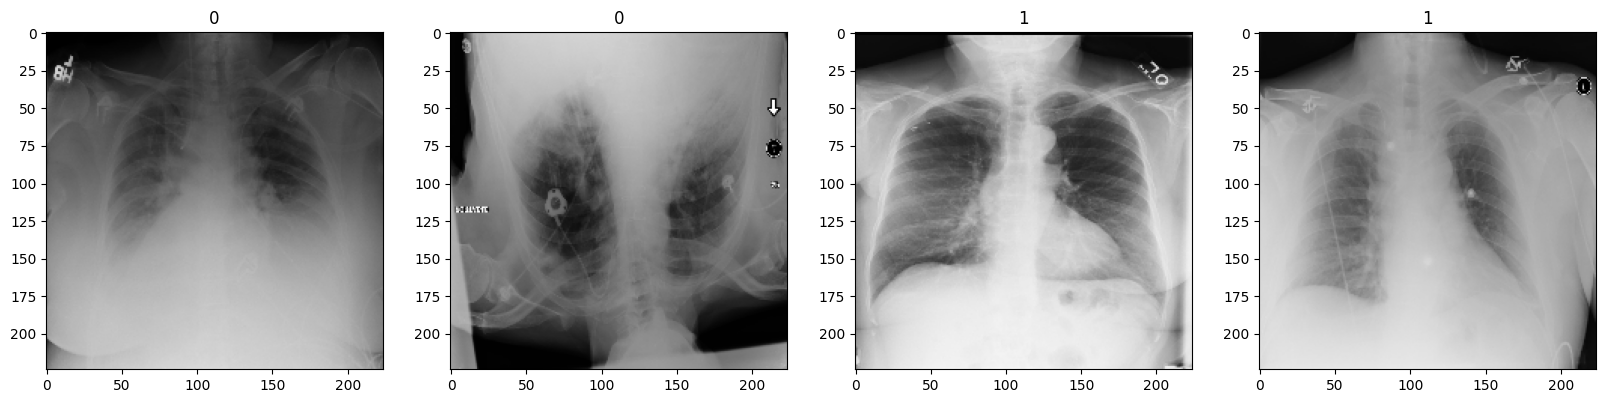

In [22]:
fig,ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [23]:
data = data.map(lambda x,y: (x/255,y))

In [24]:
batch = data.as_numpy_iterator()

In [25]:
batch = batch.next()

In [26]:
print(batch[0][0].min(), batch[0][0].max())

0.0 0.82016987


In [27]:
len(data)

1125

In [28]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.2)

In [29]:
print(train_size,val_size,test_size)

787 112 225


In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [31]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [32]:
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [33]:

from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

from keras.layers import GlobalAveragePooling2D, BatchNormalization


def create_chexnet(chexnet_weights = None,input_size=(224,224)):
    
    model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,),weights=None) 
    
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation="sigmoid", name="chexnet_output")(x)

    chexnet = tf.keras.Model(inputs = model.input,outputs = x)
    return chexnet

In [34]:
model = create_chexnet()
model.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

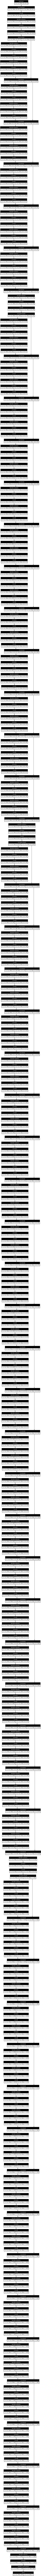

In [36]:

chexnet = create_chexnet()
chexnet.trainable = False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)


In [37]:
hist = model.fit(
    train,
    epochs=50,
    validation_data=val,
    batch_size = 16,
    callbacks=callbacks_list
)

Epoch 1/50


I0000 00:00:1719130627.093654     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


787/787 ━━━━━━━━━━━━━━━━━━━━ 353s 255ms/step - accuracy: 0.7104 - loss: 0.5546 - val_accuracy: 0.6518 - val_loss: 0.6998 - learning_rate: 0.0010
Epoch 2/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 191s 242ms/step - accuracy: 0.8174 - loss: 0.4078 - val_accuracy: 0.7712 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 3/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 192s 243ms/step - accuracy: 0.8525 - loss: 0.3494 - val_accuracy: 0.8510 - val_loss: 0.3600 - learning_rate: 5.0000e-04
Epoch 4/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 192s 244ms/step - accuracy: 0.8664 - loss: 0.3183 - val_accuracy: 0.5056 - val_loss: 0.8232 - learning_rate: 5.0000e-04
Epoch 5/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 192s 244ms/step - accuracy: 0.8786 - loss: 0.3000 - val_accuracy: 0.6797 - val_loss: 0.7232 - learning_rate: 5.0000e-04
Epoch 6/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 192s 244ms/step - accuracy: 0.8847 - loss: 0.2717 - val_accuracy: 0.8823 - val_loss: 0.2869 - learning_rate: 2.5000e-04
Epoch 7/50
787/787 ━━━━━━━━━━━━━━━━━━━━ 191s 243ms/step - a

In [38]:
from tensorflow.keras.models import load_model

model.save('model.h5') 

In [39]:
loss, accuracy = model.evaluate(test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 114s 109ms/step - accuracy: 0.8927 - loss: 0.4706


In [40]:
loss, accuracy = model.evaluate(val)

112/112 ━━━━━━━━━━━━━━━━━━━━ 90s 106ms/step - accuracy: 0.8968 - loss: 0.4288


In [45]:
import numpy as np
import tensorflow as tf

# Initialize counters for correct and wrong predictions
correct_predictions = 0
wrong_predictions = 0

# Lists to collect true and predicted labels
true_labels = []
predicted_labels = []

# Counters for each class
c_o = 0
c_l = 0

for image, ground_truth_label in test.as_numpy_iterator():
    # Make prediction on the image
    predicted_prob = model.predict(image)[0][0]

    # Convert predicted probability to binary prediction
    predicted_label = 1 if predicted_prob > 0.5 else 0

    # Append the true and predicted labels to the lists
    true_labels.append(ground_truth_label[0])  # Access the first element of ground_truth_label
    predicted_labels.append(predicted_label)

    # Compare predicted label with ground truth label
    if predicted_label == ground_truth_label[0]:
        correct_predictions += 1
        if predicted_label == 0:
            c_o += 1
        elif predicted_label == 1:
            c_l += 1
    else:
        wrong_predictions += 1

# Calculate total accuracy
total_predictions = correct_predictions + wrong_predictions
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

# Print the evaluation results
print("Total Predictions:", total_predictions)
print("Correct Predictions:", correct_predictions)
print("Wrong Predictions:", wrong_predictions)
print("Accuracy:", accuracy)
print("Class 0 Accuracy:", c_o / (c_o + c_l) if (c_o + c_l) > 0 else 0)
print("Class 1 Accuracy:", c_l / (c_o + c_l) if (c_o + c_l) > 0 else 0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [49]:
'''from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))'''


'from sklearn.metrics import confusion_matrix, classification_report\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Calculate confusion matrix\nconf_matrix = confusion_matrix(true_labels, predicted_labels)\nprint("Confusion Matrix:")\nprint(conf_matrix)\n\n# Visualize the confusion matrix\nplt.figure(figsize=(10, 7))\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\')\nplt.xlabel(\'Predicted Labels\')\nplt.ylabel(\'True Labels\')\nplt.title(\'Confusion Matrix\')\nplt.show()\n\n# Print the classification report\nprint("Classification Report:")\nprint(classification_report(true_labels, predicted_labels))'

In [47]:
# Display the counts of correct and wrong predictions
print("Correct Predictions:", correct_predictions)
print("Wrong Predictions:", wrong_predictions)
print("Predicted True Negatives 0:", c_o)
print("predicted True Positives 1:", c_l)

Correct Predictions: 195
Wrong Predictions: 30
Predicted True Negatives 0: 94
predicted True Positives 1: 101


In [48]:
from sklearn.metrics import classification_report

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for image, ground_truth_label in test.as_numpy_iterator():
    # Make prediction on the image
    predicted_prob = model.predict(image)[0][0]

    # Convert predicted probability to binary prediction
    predicted_label = 1 if predicted_prob > 0.5 else 0

    # Append true label and predicted label to lists
    true_labels.append(ground_truth_label[0])  # Access the first element of ground_truth_label
    predicted_labels.append(predicted_label)

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

In [51]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np

def preprocess_image(image_path):
    # Load the image with target size
    img = keras_image.load_img(image_path, target_size=(224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image to [0, 1] range
    return img_array

def predict_image(image):
    # Make prediction on the image
    predicted_prob = model.predict(image)[0][0]
    predicted_class = 'Normal'if predicted_prob > 0.5 else 'Effusion'
    return predicted_class

# Example usage
image_path = '/kaggle/working/Effusion/00014362_012_1307_aug1.png'  # Path tooaed image
image = preprocess_image(image_path)
predicted_class = predict_image(image)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted Class: Effusion
